# Transformers

In [ ]:
import pandas as pd
from tqdm import tqdm
from transformers import AutoConfig, AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np
from cleantext import clean

In [18]:
comments_df = pd.read_csv("data/youtube_comments_500.csv")
comments_df["Comments"] = comments_df["Comments"].astype(str)

def clean_text(text:str):
    text = clean(text, no_emoji=True, lang="de")
    new_text = []
    for token in text.split(" "):
        if not token.startswith('@') and not token.startswith('http'):
            new_text.append(token)
    return " ".join(new_text)

comments_df["Comments"] = comments_df["Comments"].apply(lambda text: clean_text(text))
comments_df =comments_df[comments_df.Comments != ""]
comments_df

,Unnamed: 0,Comments
0,0,wollt ihr jetzt jeden tag einen großen bericht...
1,1,"wenn scholz alles besser weiss, wieso braucht ..."
2,2,die grünen hatten früher das peace zeichen als...
3,3,der westen ist ein kriegstreiber bis es zu ein...
4,4,frieden schaffen ohne waffen.
...,...,...
406237,406237,"kann jeder deutscher werden ,kein problem sola..."
406238,406238,dann nimm die leute bei dir auf und verpflege ...
406239,406239,als staatenloser hatt mans aber auch nicht lei...
406240,406240,wann kommt der blackout? kinder könnt ihr ja e...


In [ ]:
model_name = "oliverguhr/german-sentiment-bert"
sentiment_tokenizer = AutoTokenizer.from_pretrained(model_name)
sentiment_model_config = AutoConfig.from_pretrained(model_name)
sentiment_model = AutoModelForSequenceClassification.from_pretrained(model_name)

label_list = []
score_list = []

for text in tqdm(comments_df.Comments.to_list()):
    tokenized_input = sentiment_tokenizer(text, padding=True, truncation=True, return_tensors='pt', max_length=512)
    output = sentiment_model(**tokenized_input)
    predictions = torch.nn.functional.softmax(output.logits, dim=-1)
    predictions = predictions.detach().numpy()[0]
    label_list.append(sentiment_model_config.id2label[np.argsort(predictions)[::-1][0]])
    score_list.append(max(predictions))

comments_df["sentiment"] = label_list
comments_df["sentiment_score"] = score_list
comments_df.to_csv("data/sentiments.csv")

In [20]:
comments = pd.read_csv("data/sentiments.csv")
comments.head(10)

,Unnamed: 0.1,Unnamed: 0,Comments,sentiment,sentiment_score
0,0,0,wollt ihr jetzt jeden tag einen großen bericht...,negative,0.997865
1,1,1,"Wenn Scholz alles besser weiss, wieso braucht ...",negative,0.922022
2,2,2,Die Grünen hatten Früher das Peace Zeichen als...,neutral,0.682787
3,3,3,Der Westen ist ein Kriegstreiber bis es zu ein...,neutral,0.994764
4,4,4,Frieden schaffen ohne Waffen.,neutral,0.957964
5,5,5,"Donnor, dann sag Putin, er soll aus der Ukrain...",neutral,0.998527
6,6,6,"Kanal Sahra Wagenknecht: Erst Panzer, dann Kam...",neutral,0.524188
7,7,7,"Donnor, beweis deine Behauptung, die Ukraine w...",neutral,0.779697
8,8,8,Deutschland wird mit der Lieferung nichts gute...,neutral,0.997424
9,9,9,Warum? Frieden schaffen mit Waffen. Denk mal a...,negative,0.891107


(0.0, 0.65)

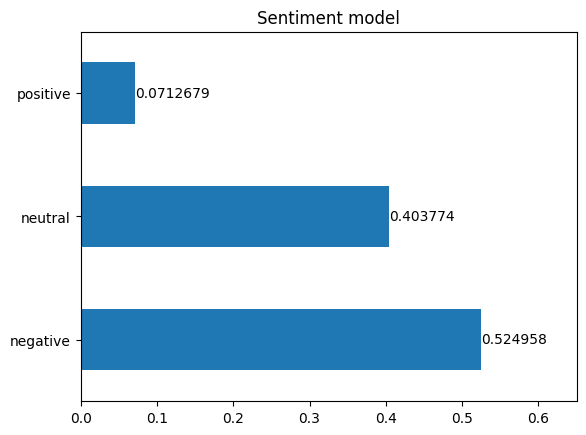

In [16]:
ax = comments["sentiment"].value_counts(normalize=True).plot(kind="barh", title="Sentiment model")
ax.bar_label(ax.containers[0])
ax.set_xlim(0,0.65)